# The Environment

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, nbinom, beta, poisson, gamma, norm, geom
from collections import namedtuple
import pandas as pd
import csv

N_DAYS = 100
N_WORKERS = 10
MAX_PARTS = 10
SHORT_ENV = (100, 42)
LONG_ENV = (3000, 123)
benchmarks = {}
envs = {}
class Job:
    def __init__(self, name, reqs, parts, complication, soft_deadline, hard_deadline, payment):
        self.name = name
        self.n_workers = reqs
        self.parts = parts
        self.parts_completed = 0
        self.days_worked = 0
        self.days_passed = 0
        self.complication_probability = complication
        self.soft_deadline = soft_deadline
        self.hard_deadline = hard_deadline
        self.payment = payment
        self.final_payment = -1
        self._progression=create_job_progression(parts, complication)
        self.completed = False
        self.failed = False
    
    def parts_remaining(self):
        return self.parts - self.parts_completed
    
    def soft_deadline_remaining(self):
        return self.soft_deadline - self.days_passed
    
    def hard_deadline_remaining(self):
        return self.hard_deadline - self.days_passed
    
    def payment_current(self):
        if self.hard_deadline_remaining() <= 0:
            return int(np.round(-0.2 * self.payment))
        elif self.soft_deadline_remaining() <= 0:
            n_days_past = np.abs(self.soft_deadline_remaining() - 1)
            return int(np.round((1 - 0.15*n_days_past) * self.payment))
        else:
            return self.payment 
        
    def expected_length(self, current=True):
        parts = self.parts if not current else self.parts_remaining()
        if parts == 0:
            return 0 
        return 1 + (parts-1)*self.complication_probability

    def upper_length(self, current=True):
        parts = self.parts if not current else self.parts_remaining()
        if parts == 0:
            return 0
        return int(1 + binom(parts-1, self.complication_probability).ppf(0.95))
        
    def lower_length(self, current=True):
        parts = self.parts if not current else self.parts_remaining()
        if parts == 0:
            return 0
        return int(1 + binom(parts-1, self.complication_probability).ppf(0.05))
        
    def return_rate(self, current=True, omniscient=False):
        parts = self.parts if not current else self.parts_remaining()
        payment = self.payment if not current else self.payment_current()
        if omniscient:
            worked = self.days_worked if current else 0
            length = len(self._progression) - worked
        else:
            length = self.expected_length(current)
        if parts == 0:
            return 0
        return payment / (self.n_workers * length)
    
    def advance_day(self):
        if not self.is_ended():
            self.days_passed += 1
        if self.hard_deadline_remaining() <= 0 and not self.completed:
            self.failed = True
            self.on_time = False
            self.final_payment = self.payment_current()

    def work(self):
        self.parts_completed += self._progression[self.days_worked]
        self.days_worked += 1
        if self.parts_remaining() == 0:
            self.completed = True
            self.on_time = self.soft_deadline_remaining() > 0
            self.final_payment = self.payment_current()
        
    def is_ended(self):
        return self.failed or self.completed
    
    def last_progress(self):
        if self.days_worked == 0:
            return 0
        else:
            return self._progression[self.days_worked - 1]
        
    def __str__(self):
        return (f'{self.name}: ' + 
                f'{self.n_workers} Workers, ' +
                f'{self.parts_remaining()} Parts, ' + 
                f'{self.complication_probability*100:2.0f}%, ' + 
                f'{self.soft_deadline_remaining():2}/{self.hard_deadline_remaining():2} Deadlines, ' +
                f'{self.payment_current()} Cents')
    
    
def create_job_progression(parts, complication_prob):
    dist = geom(complication_prob)
    progression = []
    while parts > 0:
        day_progress = dist.rvs()
        parts -= day_progress
        if parts >= 0:
            progression.append(day_progress)
        else:
            progression.append(day_progress + parts)
    return progression


def create_random_job(name, threshold=1.3):
    name = name
    parts = MAX_PARTS
    
    req_diff = np.maximum(0, norm.rvs(loc=1.2,scale=0.2))
    n_workers = 1 + binom.rvs(n=9, p=0.18*req_diff)
    
    job_diff = np.maximum(0, norm.rvs(loc=1.4,scale=0.1))
    time_diff = beta.rvs(a=9.6,b=5.2)
    
    complication_probability = beta.rvs(a=1.7*job_diff, b=3.5)
    completion_dist = binom(parts-1, complication_probability)
    soft_deadline = int(min(2*MAX_PARTS, np.ceil((1+completion_dist.ppf(0.8))/time_diff)))
    hard_deadline = int(min(2*MAX_PARTS, np.ceil((1+completion_dist.ppf(0.8))/time_diff**1.8)))
    
    expected_length = 1 + (parts-1)*complication_probability
    expected_worker_days = expected_length*n_workers
    urgency = expected_length / soft_deadline
    slack_days = soft_deadline - expected_length
    
    mean_rate = 0.015
    urgency_cent = (urgency-0.45)/0.1
    workers_cent = (n_workers-3.0)/1.24
    length_cent = (expected_length-4.5)/1.7
    mean_payment_rate = mean_rate * np.exp(0.05*(req_diff-1.2)/0.15 + 
                                           0.05*(job_diff-1.4)/0.1 + 
                                           0.05*(time_diff-0.55)/0.15 + 
                                           0.15*workers_cent + 
                                           -0.10*length_cent + 
                                           0.22*urgency_cent + 
                                           -0.15*(slack_days-5.4)/2.6 + 
                                           -0.03*np.maximum(0,workers_cent)*np.maximum(0,length_cent) + 
                                           0.04*np.maximum(0,urgency_cent)*np.maximum(0,workers_cent) + 
                                           0.07*np.maximum(0,urgency_cent)*np.maximum(0,-length_cent) + 
                                           0.04*np.maximum(0,urgency_cent)*np.maximum(0,-length_cent)*np.maximum(0,workers_cent)
                                          )
    std = 0.01
    scale = std**2 / mean_payment_rate
    payment_rate = gamma.rvs(a=mean_payment_rate/scale, scale=scale)
    if payment_rate*100 < threshold:
        return create_random_job(name, threshold)
    payment = np.maximum(1,int(payment_rate*expected_worker_days*100))
    return Job(name, n_workers, parts, complication_probability, soft_deadline, hard_deadline, payment)


def jobs_str(jobs, progresses=False, status_name="Status", statuses=None, worked=None, current=True, omniscient=False):
    progresses = progresses or (worked is not None)
    header = ""
    if statuses:
        header += f"{status_name:<11}| "
    header += f"{'Name':<10} {'Workers':<10}"
    if progresses:
        header += f" {'Progress':<15}"
    header += f" {'Length':<20} {'Deadlines':<15} {'Payment':<15} {'Rate':<10}"
    if omniscient:
        header += f" {'Real Rate':<10}"
    output_str = header + '\n'
    
    if statuses:
        output_str += '-'*11 + '+-'
    output_str += '-'*21
    if progresses:
        output_str += '-'*16
    output_str += '-'*64
    if omniscient:
        output_str += '-'*11
    output_str += '\n'
    for job in jobs:
        if statuses:
            output_str += f"{statuses[job.name]:^11}| "
        name_str, res_str, payment_str, deadline_str, length_str, rate_str = common_job_str(job, current=current)
        output_str += f"{name_str:<10} {res_str:^10}"
        if progresses:
            if worked is None:
                perc_comp = job.parts_completed / job.parts * 100
                progress = f"{perc_comp:.0f}%"
            else:
                parts_completed_this_day = job.last_progress() * worked.setdefault(job.name, 0)
                progress = progress_str(job, parts_completed_this_day)
            output_str += f" {progress:<15}"
        output_str += f" {length_str:<20} {deadline_str:<15} {payment_str:<15} {rate_str:<10}"
        if omniscient:
            real_rate_str = f" {job.return_rate(current,omniscient):2.1f} Cents"
            output_str += f" {real_rate_str:<10}"
        output_str += '\n'
    return output_str


def progress_str(job, completed_this_day, include_zero=False):
    perc_comp = job.parts_completed / job.parts * 100
    added_perc_comp = completed_this_day / job.parts * 100
    out = f"{perc_comp:.0f}%"
    if include_zero or completed_this_day > 0:
        out += f" (+{added_perc_comp:.0f}%)"
    return out


def common_job_str(job, current=True):
    s_deadline = job.soft_deadline_remaining() if current else job.soft_deadline
    h_deadline = job.hard_deadline_remaining() if current else job.hard_deadline
    pay = job.payment_current() if current else job.payment
    if s_deadline <= 0:
        payment_str = f"${pay/100:.2f}(${job.payment/100:.2f})"
    else:
        payment_str = f"${pay/100:.2f}"
    deadline_str = f"{s_deadline:2}/{h_deadline} Days"
    length_str = f"{job.expected_length(current):2.1f} Days [{job.lower_length(current)}--{job.upper_length(current)}]"
    rate_str = f"{job.return_rate(current):2.1f} Cents"
    return (job.name,
            job.n_workers,
            payment_str,
            deadline_str,
            length_str,
            rate_str)


class DayHistory:
    def __init__(self, day, offers, offer_actions, jobs_before, job_actions):
        self.day = day
        self.offers = offers
        self.offer_actions = offer_actions
        self.jobs = jobs_before
        self.job_actions = job_actions
        self.ended = [job for job in jobs_before if job.is_ended()]
        self.ended_actions = [job_actions[i] for i in range(len(job_actions)) if self.jobs[i] in self.ended]
        self._n_workers_assigned = None
        self._utilization = None
        self._active_worker_rate = [None,None]
        self._worker_rate = [None, None]
        self._average_length = [None, None]
        self._average_workers = None
        self._expected_commitment = [None, None]
        self._value = None
        
    def get_taken_jobs(self):
        return [self.offers[i] for i in range(len(self.offers)) if self.offer_actions[i] == 1]
    
    def get_untaken_jobs(self):
        return [self.offers[i] for i in range(len(self.offers)) if self.offer_actions[i] != 1]
    
    def get_worked_jobs(self):
        return [self.jobs[i] for i in range(len(self.jobs)) if self.job_actions[i] == 1]
    
    def get_n_workers_assigned(self):
        if self._n_workers_assigned is None:
            self._n_workers_assigned = sum(job.n_workers for job in self.get_worked_jobs())
        return self._n_workers_assigned

    def get_utilization(self, n_workers=None):
        n = N_WORKERS if n_workers is None else n_workers
        return self.get_n_workers_assigned()/n

    def get_worker_rate(self, n_workers=None, current=False):
        if self._worker_rate[int(current)] is None:
            n = N_WORKERS if n_workers is None else n_workers
            tot_return = sum(job.n_workers*job.return_rate(current) for job in self.get_worked_jobs())
            self._worker_rate[int(current)] = tot_return/n
        return self._worker_rate[int(current)]

    def get_active_worker_rate(self, n_workers=None, current=False):
        n = N_WORKERS if n_workers is None else n_workers
        if self.get_n_workers_assigned() == 0:
            return 0
        return self.get_worker_rate(current)*n/self.get_n_workers_assigned()

    def get_average_length(self, current=True):
        if len(self.jobs) == 0:
            return 0
        if self._average_length[int(current)] is None:
            self._average_length[int(current)] = np.mean([job.expected_length(current) for job in self.jobs])
        return self._average_length[int(current)]

    def get_average_workers(self):
        if len(self.jobs) == 0:
            return 0
        if self._average_workers is None:
            self._average_workers = np.mean([job.n_workers for job in self.jobs])
        return self._average_workers

    def get_expected_commitment(self, current=True):
        if self._expected_commitment[int(current)] is None:
            self._expected_commitment[int(current)] = sum(job.expected_length(current)*job.n_workers for job in self.jobs)
        return self._expected_commitment[int(current)]

    def get_payment(self):
        if self._value is None:
            self._value = sum(job.final_payment for job in self.ended)
        return self._value

    
    def get_pretty_str(self, include_taken=False):
        outstr = ''
        outstr += self.get_offers_pretty_str()
        outstr += '\n\n'
        outstr += self.get_active_pretty_str(include_taken=include_taken)
        if self.ended:
            outstr += '\n\n'
            outstr += self.get_ended_pretty_str()
        outstr += '\n' + f"{self.get_n_workers_assigned()}/{N_WORKERS} Workers assigned.\n" 
        return outstr
        
    def get_offers_pretty_str(self, actions=True):
        out = 'Job Offers\n'
        if not actions:
            return out + jobs_str(self.offers)
        statuses = {}
        for i, job in enumerate(self.offers):
            if self.offer_actions[i] == 0:
                statuses[job.name] = ''
            elif self.offer_actions[i] == 1:
                statuses[job.name] = 'X'
            elif self.offer_actions[i] == -1:
                statuses[job.name] = 'Tried'
            else:
                statuses[job.name] = '?'
        return out + jobs_str(self.offers, status_name="Accepted?", statuses=statuses)

    def get_active_pretty_str(self, actions=True, include_ended=False, include_taken=False):
        out = 'Active Jobs\n'
        if include_ended:
            jobs_to_str = self.jobs
        else:
            jobs_to_str = [job for job in self.jobs if not job.is_ended()]
        if include_taken:
            jobs_to_str += self.get_taken_jobs()
        if not actions:
            return out + jobs_str(jobs_to_str)
            
        statuses = {}
        worked = {}
        for i, job in enumerate(self.jobs):
            if self.job_actions[i] == 1:
                statuses[job.name] = "X"
                worked[job.name] = 1
            elif self.job_actions[i] == -1:
                statuses[job.name] = "Tried"
                worked[job.name] = 0
            elif self.job_actions[i] == 0:
                statuses[job.name] = ""
                worked[job.name] = 0
            else:
                statuses[job.name] = "?"
                worked[job.name] = 0
        if include_taken:
            for job in self.get_taken_jobs():
                statuses[job.name] = "New"
                worked[job.name] = 0
            
        return out + jobs_str(jobs_to_str, status_name="Active?", statuses=statuses, worked=worked)

    def get_ended_pretty_str(self):
        if not self.ended:
            return ""
        output_str = 'Ended Jobs\n'
        header = f"{'Outcome':<10}| {'Name':<10} {'Workers':<10} {'Progress':<15} {'Deadlines':15} {'Payment':<20}\n"
        output_str += header
        output_str += '-'*10 + '+' + '-'*75 + '\n'
        for i,job in enumerate(self.ended):
            if job.completed:
                status = "Completed"
            elif job.failed:
                status = "Failed"
            else:
                status = "?"
            parts_completed_this_day = job.last_progress() * max(0,self.ended_actions[i])
            name_str, res_str, payment_str, deadline_str, length_str, rate_str = common_job_str(job)
            progress = progress_str(job, parts_completed_this_day)
            payment_str = f"${job.final_payment/100:.2f}"
            output_str += f"{status:<10}| {name_str:<10} {res_str:^10} {progress:<15} {deadline_str:<15} {payment_str:<20}\n"
        return output_str

        
def flatten(lsts):
    return [item for sublist in lsts for item in sublist]
    
class EnvHistory:
    def __init__(self, n_days=None, n_workers=None):
        self.history = []
        self.n_days = N_DAYS if n_days is None else n_days
        self.n_workers = N_WORKERS if n_workers is None else n_workers
        self._reset_cache()
        
    def _reset_cache(self):
        self._n_taken = None
        self._n_workers_assigned = None
        self._total_payments = None
        self._n_ended = None
        
    def record(self, day_hist):
        self.history.append(day_hist)
        self._reset_cache()

    def get_offered(self, flattened=False):
        lsts = [day_hist.offers for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
        
    def get_taken(self, flattened=False):
        lsts = [day_hist.get_taken_jobs() for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
    
    def get_untaken(self, flattened=False):
        lsts = [day_hist.get_untaken_jobs() for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
    
    def get_ended(self, flattened=False):
        lsts = [day_hist.ended for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
    
    def get_n_taken(self):
        if self._n_taken is None:
            self._n_taken = sum(len(day_taken) for day_taken in self.get_taken())
        return self._n_taken
    
    def get_n_ended(self):
        if self._n_ended is None:
            self._n_ended = sum(len(day_ended) for day_ended in self.get_ended())
        return self._n_ended
    
    def acceptance_rate(self):
        n_untaken = sum(len(day_untaken) for day_untaken in self.get_untaken())
        return self.get_n_taken() / (self.get_n_taken() + n_untaken)
    
    def completion_rate(self):
        n_completed = sum(job.completed for job in self.get_ended(flattened=True))
        return n_completed/self.get_n_ended()
    
    def on_time_rate(self):
        n_ontime = sum(job.on_time for job in self.get_ended(flattened=True))
        return n_ontime / self.get_n_ended()
    
    def avg_accepted_length(self):
        if self.get_n_taken == 0:
            return 0
        tot_lengths = sum(job.expected_length(current=False) for job in self.get_taken(flattened=True))
        return tot_lengths / self.get_n_taken()
        
    def avg_accepted_workers(self):
        if self.get_n_taken == 0:
            return 0
        tot_workers = sum(job.n_workers for job in self.get_taken(flattened=True))
        return tot_workers / self.get_n_taken()
        
    def avg_accepted_rate(self):
        if self.get_n_taken == 0:
            return 0
        tot_rates = sum(job.return_rate(current=False) for job in self.get_taken(flattened=True))
        return tot_rates / self.get_n_taken()
    
    def get_n_workers_assigned(self):
        if self._n_workers_assigned is None:
            self._n_workers_assigned = sum(day_hist.get_n_workers_assigned() for day_hist in self.history)
        return self._n_workers_assigned
        
    def utilization(self):
        return self.get_n_workers_assigned() / (self.n_workers*len(self.history))
    
    def total_payment(self, day=None):
        if self._total_payments is None:
            self._total_payments = np.cumsum([day_hist.get_payment() for day_hist in self.history])
        if not day:
            day = len(self._total_payments)
        return self._total_payments[day-1]
    
    def utilized_rate(self):
        return self.total_payment() / self.get_n_workers_assigned()
    
    def rate(self):
        return self.total_payment() / (self.n_workers*len(self.history))

    def get_pretty_str(self):
        out = ''
        for i, day_hist in enumerate(self.history):
            out += f'Day: {i+1}: Total Payment: ${self.total_payment(i+1)/100:.2f}\n'
            out += day_hist.get_pretty_str()
            out += '\n' + '-'*120
            out += '\n' + '-'*120 + '\n'
        return out
        
        
class JobEnv():
    def __init__(self, seed=None, n_days=None, n_workers=None, threshold=1.3, debt=0):
        self.n_days = n_days if n_days is not None else N_DAYS
        self.max_jobs = 20
        self.max_arrivals = 7
        self.n_workers = n_workers if n_workers is not None else N_WORKERS
        self.threshold = threshold
        self.jobs = []
        self.offers = []
        self.debt=debt
        
        n_obs_jobs = self.max_jobs + self.max_arrivals
        self.reset(seed)
        
        
    def reset(self, seed=None):
        if seed:
            np.random.seed(seed)
        self.total_payment = -self.debt
        self.current_day = 0
        self.jobs = []
        self.all_jobs = []
        self.history = EnvHistory(self.n_days, self.n_workers)
        for day in range(self.n_days):
            self.all_jobs.append(self.generate_jobs(day))
        self.offers = self.all_jobs[self.current_day]
        

    def soft_reset(self):
        self.total_payment = -self.debt
        self.current_day = 0
        self.jobs = []
        self.history = EnvHistory(self.n_days, self.n_workers)
    
    def step(self, job_acceptances, work_actions, record=True):
        if self.current_day >= self.n_days:
            return
        
        used = 0
        realized_actions = copy.copy(work_actions)
        active_jobs = self.jobs.copy() # Copy so removing jobs from self.jobs doesn't mess up iterating
        for i,job in enumerate(active_jobs):
            if work_actions[i] ==1:
                if used + job.n_workers <= self.n_workers:
                    used += job.n_workers
                    self.total_payment += self.process_job(job)
                else:
                    realized_actions[i] = -1
                
        self.total_payment += self.advance_day(active_jobs)
        
        realized_acceptances = copy.copy(job_acceptances)
        for i, job in enumerate(self.offers):
            if job_acceptances[i] == 1:
                if len(self.jobs) < self.max_jobs:
                    self.take_job(job)
                else:
                    realized_acceptances[i] = -1

        if record:
            self.history.record(DayHistory(self.current_day, copy.deepcopy(self.offers), realized_acceptances, copy.deepcopy(active_jobs), realized_actions))
        if self.current_day < self.n_days:
            self.offers = self.all_jobs[self.current_day]
        else:
            self.offers = []

    def insufficient_workers(self, actions, active_jobs):
        used_reqs = 0
        for i,job in enumerate(active_jobs):
            if actions[i]==1:
                used_reqs += job.n_workers
        return used_reqs > self.n_workers
    
    
    def process_job(self, job) -> float:
        job.work()
        if job.completed:
            self.complete_job(job)
            return job.final_payment
        else:
            return 0

            
    def advance_day(self, active_jobs):
        incurred_penalties = 0
        self.current_day += 1
        for job in active_jobs:
            if not job.is_ended():
                job.advance_day()
            if job.failed:
                self.complete_job(job)
                incurred_penalties += job.final_payment
        return incurred_penalties
            
        
    def generate_jobs(self, day) -> list:
        jobs_arrived = min(poisson.rvs(mu=2), self.max_arrivals)
        return [create_random_job(f"{day+1}-{i}", self.threshold) for i in range(jobs_arrived)]
            
        
    def complete_job(self, job):
        job.final_payment = job.payment_current()
        self.jobs.remove(job)

        
    def take_job(self, job):
        self.jobs.append(job)
 

    def get_detailed_info(self):
        active_job_names = [job.name for job in self.jobs]
        return self.episode, self.current_day, self.n_workers, len(self.jobs), active_job_names
    

    def get_pretty_str(self, all_days=False):
        now_available_str = f'Day: {self.current_day+1}: Total Payment: ${self.total_payment/100:.2f}\n'
        if self.current_day < self.n_days:
            now_available_str += "Job Offers\n"
            now_available_str += jobs_str(self.offers)

        if all_days:
            out = self.history.get_pretty_str()
            out += '\n' + now_available_str
            if self.current_day > 0:
                hist = self.history.history[-1]
                out += '\n' + hist.get_active_pretty_str(include_taken=True)
        else:
            out = now_available_str
            if self.current_day > 0:
                hist = self.history.history[-1]
                out += (
                     '\n' + hist.get_active_pretty_str(include_taken=True) +
                     '\n' + hist.get_ended_pretty_str() +
                     '\n' + f"{hist.get_n_workers_assigned()}/{self.n_workers} Workers assigned.\n" +
                     '\n' + '-'*120 + 
                     '\n' + '-'*120 + '\n' + 
                     '\n' + hist.get_offers_pretty_str()
                     )
        return out
    
    
def pay_schedule(job):
    pays = []
    for days in range(1,job.hard_deadline + 10):
        if days > job.hard_deadline:
            pays.append(-int(0.2*job.payment))
        elif days > job.soft_deadline:
            pays.append(int((1 - 0.15*(days - job.soft_deadline))*job.payment))
        else:
            pays.append(job.payment)
    return pays


Strategy = namedtuple('Strategy', ['name','offer_strat','work_strat'])
FixedStrategy = namedtuple('FixedStrategy', ['name', 'seed','actions'])

kevin_actions_42 =[
    ([1,1,1,1],[]), ([1,0,1],[1,1,1,1]), ([],[0,1,0,1,1,1]), ([0,0],[0,1,0,1,1,1]),  ([1],[1,1,0,1,1]),
    ([0,0,1],[1,0,1,1]),  ([0],[0,1,0,1]), ([1],[0,1,0,1]), ([1,1,1],[0,0,1,1]), ([0,0],[0,1,1,0,0,0,1]),
    ([0,1,1,0],[0,1,0,1,1,1]), ([0,1,1],[0,1,1,0,1,1,0]), ([0],[0,1,1,0,0,0,0,1]), ([0],[0,1,0,1,0,1,0,1]),  ([],[0,1,1,0,1,0,0]),
    ([1,1],[0,0,0,1,1,1]), ([0,1],[0,1,1,1,0,0,1]), ([0],[0,1,1,1,0,0,1]), ([1,0],[0,1,1,0]), ([],[1,1,1,1]),
    ([0,1,1,0,1],[1,1,1]),  ([0,0],[0,1,1,1]), ([],[0,1,1,1]), ([0,1],[0,1,1,1]), ([1,1,1],[1,1,1]),
    ([0,0,1,1,0],[1,1,0,1,0,1]), ([0,0,1],[0,0,1,0,1,1,1]), ([0,0],[1,1,0,0,1,1]), ([1,0],[1,0,0,1,1,1]), ([0,0,1],[1,0,0,1,1,0,1]),
    ([0,0,1],[0,0,0,1,1,0,1]), ([],[0,0,0,1,1,0,1,0]), ([0,1,0,0],[1,0,1,0,1,0]), ([0,1,0],[1,0,1,0,1,0,0]), ([0,0,0,0],[0,0,0,1,1,0,0,0]),
    ([0],[0,0,0,1,1,0,0]), ([],[0,0,1,1,0,0]), ([0,1,0,0],[1,1,1,0]), ([0,0],[1,1,1,0,0]), ([],[1,0,1,1,0]),
    ([0,1,1],[1,1,0,1]), ([0,0,1,1],[1,1,0,0,1,1]), ([1,0,0,0],[0,0,1,1,1,1]), ([0,0],[0,1,1,0,0,1]), ([0,0,1,0],[0,1,1,0,1,0]),
    ([],[0,0,1,1,1,0,0]), ([1],[0,0,1,1,0,1,0]), ([0],[0,0,0,1,1,0,1]), ([],[0,0,1,1,0,1]), ([0,0,0],[1,1,1,0,0,1]),
    ([0,1],[0,1,1]), ([0],[0,1,1,0]), ([1],[1,1,1]), ([1,1],[1,1,1]), ([0],[1,1,1]),
    ([1,1],[1,1,1]), ([1,0,0],[1,0,1,0,1]), ([0,1],[1,1,1,0,1]), ([1,0],[1,1,1,1,0]), ([],[1,1,1,1,0,0]),
    ([1,0,0],[1,1,1,0,0]), ([],[1,1,0,0,1]), ([0],[0,1,1]), ([],[0,1,1]), ([0,0],[0,1,1]),
    ([],[0,1,1]), ([0,0,1,0],[0,1,1]), ([1],[0,1,1,0]), ([1],[0,1,0,1,0]), ([0,1],[0,1,0,0,1,1]),
    ([0,1],[0,1,0,0,1,1,1]), ([0,0],[0,1,1,1,1,1,0]), ([],[1,1,1,1,1]), ([0,1,0,1],[1,1,1,1]), ([1],[1,1,1,0]),
    ([1,0],[1,1,1]), ([1,1],[1,1,1,0]), ([1],[1,1,1,1,0]), ([1,1,1],[0,1,1,1,1]), ([1],[1,1,1,0,1,0,0,1]),
    ([1,0],[1,1,1,0,0,1,0,1,0]), ([0,0],[0,1,0,0,0,1,1,0,1]), ([0,1,0,0],[0,1,0,0,0,1,1,1,0]), ([0,0],[1,0,0,0,1,1,1,0,0,0]), ([1],[0,0,0,0,1,1,1,0]),
    ([0,0,0,1,0],[1,1,0,0,1,0,1,0,0]), ([0,0,1,0],[0,0,1,1,1,0,0,0]), ([0,0,0,0,0,0],[0,0,1,1,0,0,1,0]), ([0,0],[0,0,0,1,0,0,0,1]), ([1,0,0],[0,0,1,1,1,1]),
    ([0,0],[0,0,1,1,1]), ([0,0,0],[0,0,1,1,1]),  ([1],[0,0,1,1,1]), ([],[0,1,1,1,0]), ([1,0,1],[0,1,1,1,0]),
    ([0],[0,0,0,1,0,1,1]), ([1],[0,1,0,1]), ([1],[1,1,1]), ([1],[1,1,1]), ([0,1],[1,1,1]),
]
kevin_strat = FixedStrategy(name='Kevin', seed=42, actions=kevin_actions_42)

def get_env(n_days, seed):
    key = (n_days, seed)
    if key not in envs:
        envs[key] = JobEnv(n_days=n_days, seed=seed)
    return copy.deepcopy(envs[key])
    

def run_fixed_strategy(fixed_strat, n_days=None):
    n_days = max(SHORT_ENV[0], len(fixed_strat.actions)) if n_days is None else n_days
    env = get_env(n_days, fixed_strat.seed)
    actions = fixed_strat.actions
    while env.current_day < len(actions):
        acceptances, work = actions[env.current_day]
        env.step(acceptances, work)
    return env

def run_strategy(strategy, n_days=None, seed=None):
    n_days = LONG_ENV[0] if n_days is None else n_days
    seed = LONG_ENV[1] if seed is None else seed
    env = get_env(n_days,seed)
    offer_strat, work_strat = strategy.offer_strat, strategy.work_strat
    for _ in range(env.n_days):
        acceptances, work = offer_strat(env.offers, env), work_strat(env.jobs, env)
        env.step(acceptances, work)
    return env

def get_benchmarks(n_days, seed):
    return {}

def split_string_on_words(string, max_width):
    """Split a string into lines, splitting at word boundaries with a max line width."""
    words = string.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_width or not current_line:
            current_line += (" " + word) if current_line else word
        else:
            lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return lines

def get_comparison_table(envs, include_payments=False, max_column_width=11):
    metrics = [ "Strategy", 
        "Acceptance Rate", "Completion Rate", "On Time Rate",
        "Average Accepted Length", "Average Accepted Workers",
        "Average Accepted Rate", "Worker Utilization", "Utilized Rate",
        "Rate"
    ]
    if include_payments:
        metrics.append("Payments")

    split_metrics = [split_string_on_words(metric, max_column_width) for metric in metrics]
    max_lines = max(len(metric_lines) for metric_lines in split_metrics)
    padded_metrics = [[''] * (max_lines - len(lines)) + lines for lines in split_metrics]

    # Center-align each line within each metric
    aligned_metrics = [[line.center(max_column_width) for line in metric] for metric in padded_metrics]

    # Create the header
    header_lines = [' | '.join(metric[i] for metric in aligned_metrics) for i in range(max_lines)]
    header = "\n".join(header_lines) + "\n"
    separator = "-" * len(header_lines[0]) + "\n"

    # Start building the table
    outstr = header + separator

    sorted_envs = sorted(envs.items(), key=lambda item: item[1].history.rate(), reverse=True)
    # Add each environment's data
    for name, env in sorted_envs:
        row = name.ljust(max_column_width) + " | "
        hist = env.history
        metrics_data = [
            str(np.round(hist.acceptance_rate()*100,1))+"%",
            str(np.round(hist.completion_rate()*100,1))+"%",
            str(np.round(hist.on_time_rate()*100,1))+"%",
            str(np.round(hist.avg_accepted_length(),1))+" Days",
            str(np.round(hist.avg_accepted_workers(),1)),
            str(np.round(hist.avg_accepted_rate(),1))+ " Cents",
            str(np.round(hist.utilization()*100,1))+"%",
            str(np.round(hist.utilized_rate(),1))+" Cents",
            str(np.round(hist.rate(),2))+" Cents"
        ]
        if include_payments:
            metrics_data.append("$"+str(np.round(env.total_payment/100,2)))

        row += " | ".join(data.center(max_column_width) for data in metrics_data)
        outstr += row + "\n"
    return outstr

def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size).mean()

    
def plot_cumulative_payment(envs, ax):
    for name, env in envs.items():
        payments = [env.history.total_payment(day=i) for i in range(1, len(env.history.history)+1)]
        ax.plot(payments, label=name)
    ax.set_title('Cumulative Payment')
    ax.set_xlabel('Periods')
    ax.legend()

def plot_moving_average(envs, day_hist_func, title, ax, window_size=5):
    for name, env in envs.items():
        metric_values = [day_hist_func(day_hist) for day_hist in env.history.history]
        ma_values = moving_average(metric_values, window_size)
        ax.plot(ma_values, label=name)
    ax.set_xlabel('Periods')
    ax.set_title(title)
    ax.legend()

def plot_all_combined(envs, window_size=5):
    # Set up the figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # Plot on the specific axes
    plot_cumulative_payment(envs, axes[0, 0])
    plot_moving_average(envs, lambda dh: sum(job.n_workers for job in dh.jobs), "Total Workers Wanted", axes[0, 1], window_size)
    plot_moving_average(envs, lambda dh: len(dh.jobs), "Number of Jobs", axes[0, 2], window_size)
    plot_moving_average(envs, lambda dh: dh.get_expected_commitment(), "Committed WorkerDays (Expected)", axes[1, 0], window_size)
    plot_moving_average(envs, lambda dh: dh.get_utilization(), "Worker Utilization", axes[1, 1], window_size)
    plot_moving_average(envs, lambda dh: dh.get_worker_rate(), "Payment Rate", axes[1, 2], window_size)

    plt.tight_layout()
    return fig

def get_strategy_comparisons(strategies=None, fixed_strategies=None, benchmarks=True):
    long_envs = {}
    outstr = ""
    if strategies is None:
        strategies = []
    if fixed_strategies is None:
        fixed_strategies = []
    if benchmarks:
        long_envs.update(get_benchmarks(n_days=LONG_ENV[0], seed=LONG_ENV[1]))
    for strat in strategies:
        long_envs[strat.name] = run_strategy(strat, n_days=LONG_ENV[0], seed=LONG_ENV[1])
    if len(long_envs) > 0:
        outstr = "Long-run Comparisons:\n"
        outstr += get_comparison_table(long_envs)
    short_envs = {}
    if benchmarks:
        short_envs.update(get_benchmarks(n_days=SHORT_ENV[0], seed=SHORT_ENV[1]))
        fixed_strategies.append(kevin_strat)
    for strat in strategies:
        short_envs[strat.name] = run_strategy(strat, n_days=SHORT_ENV[0], seed=SHORT_ENV[1])
    for strat in fixed_strategies:
        if strat.seed == SHORT_ENV[1] and len(strat.actions) >= SHORT_ENV[0]:
            short_envs[strat.name] = run_fixed_strategy(strat, n_days=SHORT_ENV[0])
    if len(short_envs) > 0:
        outstr += '\n\nExperiment Parameters Comparisons:\n'
        outstr += get_comparison_table(short_envs, include_payments=True) 
    plots = plot_all_combined(short_envs)
    return outstr, plots
        

def fitness(offer_strat, work_strat, n_days=None, seed=None):
    n_days = LONG_ENV[0] if n_days is None else n_days
    seed = LONG_ENV[1] if seed is None else seed
    env = get_env(n_days,seed)
    for _ in range(env.n_days):
        acceptances, work = offer_strat(env.offers, env), work_strat(env.jobs, env)
        env.step(acceptances, work, record=False)
    return env.total_payment / (env.n_days * env.n_workers)

def write_csvs(name, strategies, n_days=None, seed=None):
    n_days = SHORT_ENV[0] if n_days is None else n_days
    seed = SHORT_ENV[1] if seed is None else seed
    job_filename = f'{name}_jobs.csv'
    env = get_env(n_days,seed)
    write_job_csv(job_filename, env)
    res_envs = []
    for strat in strategies:
        res_envs.append(run_strategy(strat, n_days=n_days, seed=seed))
    actions_filename = f'{name}_actions.csv'
    write_actions_csv(actions_filename, res_envs)
    summary_filename = f'{name}_summary.csv'
    write_day_histories_summary(summary_filename, res_envs)
    strats_filename = f'{name}_strategies.csv'
    with open(strats_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        headers = ['sid', 'Strategy']
        writer.writerow(headers)
        for sid, strat in enumerate(strategies):
            writer.writerow([sid, strat.name])
    
def write_actions_csv(filename, res_envs):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        headers = ['SubjectID', 'Day', 'Job Name', 'Action Type', 'Accepted/Worked On', 
                   'Parts Completed', 'Soft Deadline Remaining', 'Hard Deadline Remaining', 
                   'Current Payment', 'Payment Received']
        writer.writerow(headers)

        for sid, env in enumerate(res_envs):
            for day_hist in env.history.history:
                day = day_hist.day

                # Offer actions
                for offer, action in zip(day_hist.offers, day_hist.offer_actions):
                    writer.writerow([sid, day, offer.name, 'Offer', action, '', '', '', '', ''])

                # Job actions
                for job, action in zip(day_hist.jobs, day_hist.job_actions):
                    parts_completed = job.parts_completed
                    soft_deadline_remaining = job.soft_deadline_remaining()
                    hard_deadline_remaining = job.hard_deadline_remaining()
                    current_payment = job.payment_current()
                    payment = job.final_payment if job.is_ended() else ''
                    writer.writerow([sid, day, job.name, 'Work', action, parts_completed, 
                                     soft_deadline_remaining, hard_deadline_remaining, 
                                     current_payment, payment])

def write_job_csv(filename, env):
    # Open the file in write mode
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        headers = ['Name', 'Day', 'Workers', 'Parts', 'Complication Probability', 
                   'Soft Deadline', 'Hard Deadline', 'Payment', 'Progression']
        writer.writerow(headers)

        # Write job data
        for day, job_list in enumerate(env.all_jobs):
            for job in job_list:
                progression_str = ','.join(map(str, job._progression))
                writer.writerow([
                    job.name, day+1, job.n_workers, job.parts, np.round(job.complication_probability,3),
                    job.soft_deadline, job.hard_deadline, job.payment, progression_str
                ])
                
def write_day_histories_summary(filename, res_envs):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        headers = ['sid', 'Day', 'Job Count', 'Workers Assigned', 'Utilization', 'Worker Rate', 'Active Worker Rate',
                   'Average Length', 'Average Workers', 'Expected Commitment', 'Payment']
        writer.writerow(headers)

        for sid, env in enumerate(res_envs):
            for day_hist in env.history.history:
                writer.writerow([
                    sid,
                    day_hist.day,
                    len(day_hist.jobs),
                    day_hist.get_n_workers_assigned(),
                    np.round(day_hist.get_utilization(),3),
                    np.round(day_hist.get_worker_rate(),2),
                    np.round(day_hist.get_active_worker_rate(),2),
                    np.round(day_hist.get_average_length(),1),
                    np.round(day_hist.get_average_workers(),1),
                    np.round(day_hist.get_expected_commitment(),1),
                    day_hist.get_payment()
                ])

# Strategies

## Some basic strategies and helper function to get you started

In [2]:
import random
def get_priorities(data, key=lambda x: x):
    return sorted(range(len(data)), key=lambda i: key(data[i]))

def allocate_resources(jobs, sorted_indices, available_resources):
    job_selection = [0] * len(jobs)

    for i in sorted_indices:
        job = jobs[i]
        if job.n_workers <= available_resources:
            job_selection[i] = 1  # Assign workers to this job
            available_resources -= job.n_workers  # Deduct the allocated workers from the resources

    return job_selection
                
def accept_random(p=0.5):
    def action_func(offers, env):
        actions = [int(random.random()<p) for _ in range(len(offers))]
        return actions
    return action_func
    
def accept_rate_thresh(threshold, delta=0):
    def action_func(offers, env):
        actions = []
        for job in offers:
            if job.return_rate() > threshold:
                actions.append(int(random.random()>delta))
            else:
                actions.append(int(random.random()<delta))
        return actions
    return action_func

def work_fifo(jobs, env):
    return [1]*len(jobs)

def work_shortest(jobs, env):
    # Get the indices of jobs sorted by their expected length
    priorities = get_priorities(jobs, key=lambda job: job.expected_length())
    return allocate_resources(jobs, priorities, env.n_workers)


sample_strategies = ([Strategy(f">3.1,FIFO{i}", accept_rate_thresh(3.1,0), work_fifo) for i in range(1)] +
                    [Strategy(f">2.9,Short{i}", accept_rate_thresh(2.9,0), work_shortest) for i in range(1)])



## Evaluating fitness of a strategy for a GA

In [3]:
# Note, this takes some time for the first time you run it.  Should be faster after that.
fitness(accept_rate_thresh(2.9), work_shortest)

2.6438

## Writing the outcomes of a set of strategies into a file

In [4]:
# "test" will prefix the 4 csvs creates
write_csvs('test', sample_strategies)

## Compare the performance of a set of strategies

Long-run Comparisons:
            |             |             |             |   Average   |   Average   |   Average   |             |             |            
            |  Acceptance |  Completion |   On Time   |   Accepted  |   Accepted  |   Accepted  |    Worker   |   Utilized  |            
  Strategy  |     Rate    |     Rate    |     Rate    |    Length   |   Workers   |     Rate    | Utilization |     Rate    |     Rate   
-----------------------------------------------------------------------------------------------------------------------------------------
>2.9,Short0 |    31.9%    |    85.4%    |    78.8%    |   4.4 Days  |     3.5     |  3.9 Cents  |    78.6%    |  3.4 Cents  |  2.64 Cents
>3.1,FIFO0  |    27.2%    |    83.4%    |    71.4%    |   4.4 Days  |     3.5     |  4.1 Cents  |    73.7%    |  3.5 Cents  |  2.6 Cents 


Experiment Parameters Comparisons:
            |             |             |             |   Average   |   Average   |   Average   |             |  

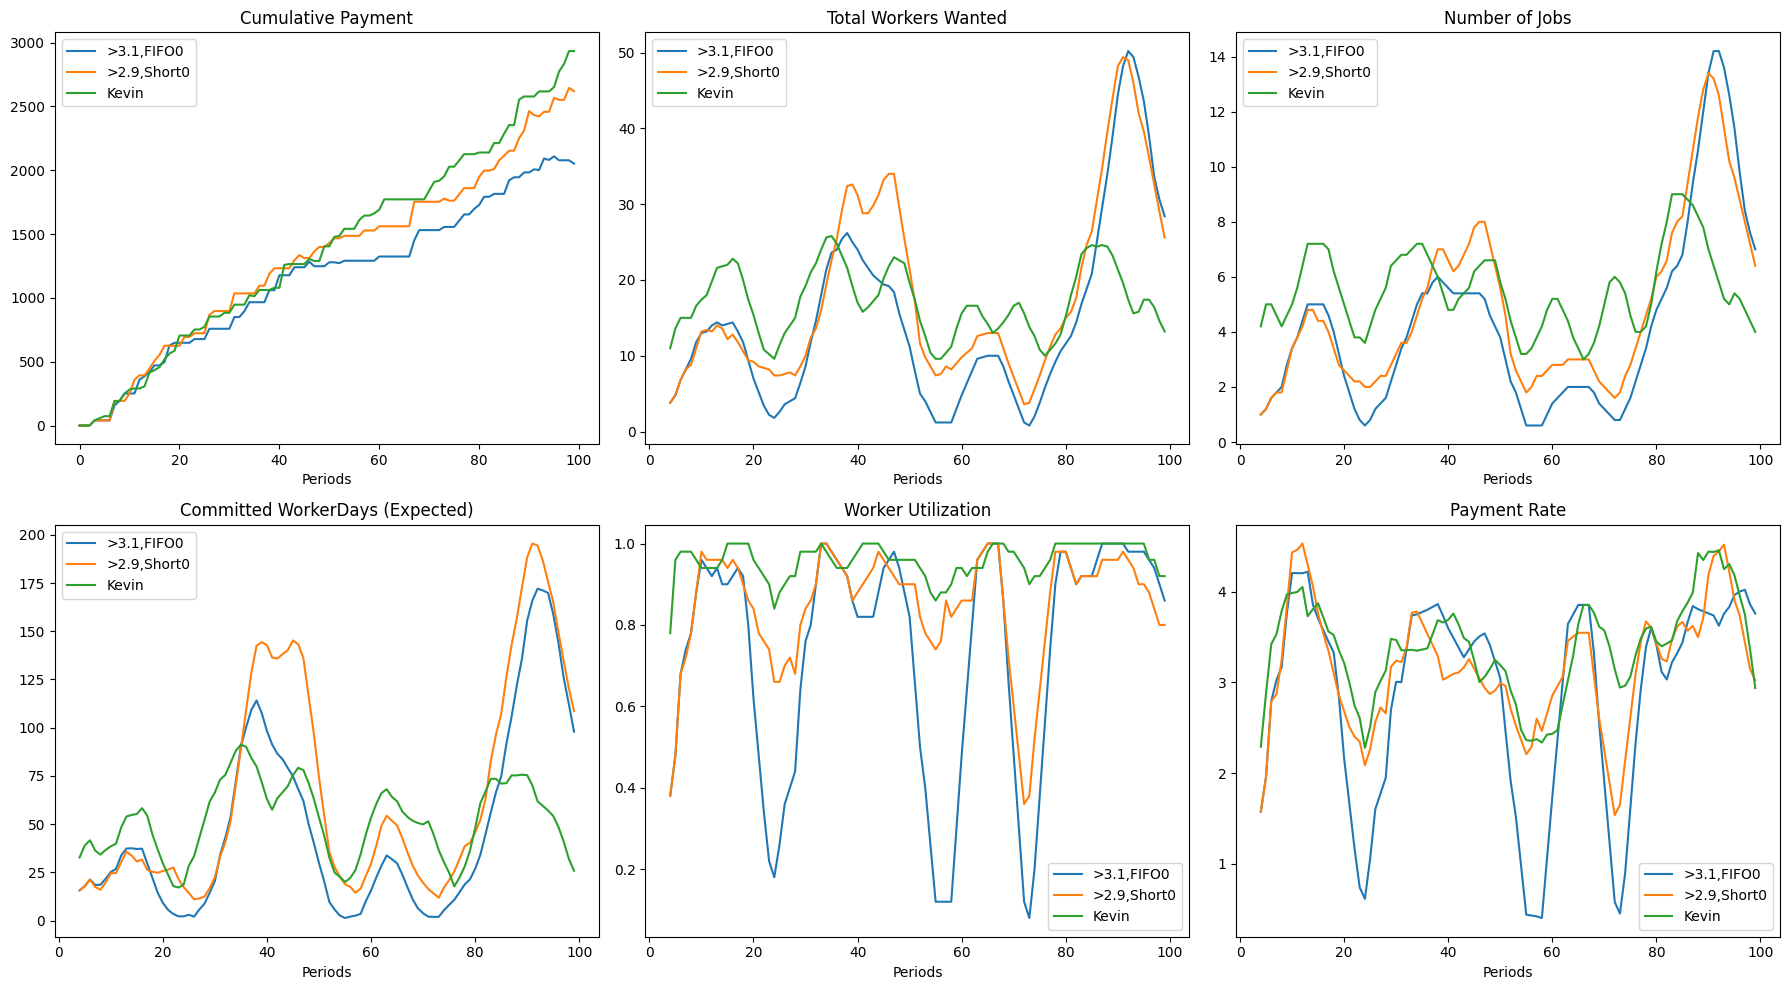

In [5]:
table_str, plots = get_strategy_comparisons(strategies=sample_strategies)
print(table_str)
plt.show(plots)

## Visualize a Strategy

In [6]:
env = run_fixed_strategy(kevin_strat)
print(env.get_pretty_str(all_days=True))

Day: 1: Total Payment: $0.00
Job Offers
Accepted?  | Name       Workers    Length               Deadlines       Payment         Rate      
-----------+--------------------------------------------------------------------------------------
     X     | 1-0            2      4.1 Days [2--6]       9/14 Days      $0.11           1.3 Cents 
     X     | 1-1            2      3.4 Days [1--6]       7/9 Days       $0.16           2.3 Cents 
     X     | 1-2            4      4.3 Days [2--7]      10/17 Days      $0.23           1.3 Cents 
     X     | 1-3            1      3.8 Days [2--6]       7/9 Days       $0.06           1.6 Cents 


Active Jobs
Name       Workers    Progress        Length               Deadlines       Payment         Rate      
-----------------------------------------------------------------------------------------------------

0/10 Workers assigned.

------------------------------------------------------------------------------------------------------------------------
--

In [7]:
env = run_strategy(sample_strategies[0], seed=SHORT_ENV[1], n_days=SHORT_ENV[0])
print(env.get_pretty_str(all_days=True))

Day: 1: Total Payment: $0.00
Job Offers
Accepted?  | Name       Workers    Length               Deadlines       Payment         Rate      
-----------+--------------------------------------------------------------------------------------
           | 1-0            2      4.1 Days [2--6]       9/14 Days      $0.11           1.3 Cents 
           | 1-1            2      3.4 Days [1--6]       7/9 Days       $0.16           2.3 Cents 
           | 1-2            4      4.3 Days [2--7]      10/17 Days      $0.23           1.3 Cents 
           | 1-3            1      3.8 Days [2--6]       7/9 Days       $0.06           1.6 Cents 


Active Jobs
Name       Workers    Progress        Length               Deadlines       Payment         Rate      
-----------------------------------------------------------------------------------------------------

0/10 Workers assigned.

------------------------------------------------------------------------------------------------------------------------
--

## Play the Experiment yourself

In [8]:
# A single day's actions are of the form ([0,1,0], [1,1,1]), the first list is which offers you accept, the second is which jobs you work on
# So, since there are four jobs in the first day in these parameters, an example first period action would be ([1,1,0,0], []).  You accept the first two offers, and have nothing to work on.
# actions is just equal to a list of all your actions across the days.  Below is an example of two periods worth of actions.
#actions = [([1,1,0,0],[]), ([1,1,0], [1,1])]
# Tip: I recommend starting a new line every 5 days.  You can scroll up and see my strategy in the sea of code up top.
actions = [#([0,1,0,1],[]), ([1,0,1],[1,1]), ([],[1,1,1,1]), ([0,0],[1,1,1,1]), ([1],[1,1,1])
          ]
my_strat = FixedStrategy(name='my_strat',actions=actions, seed=SHORT_ENV[1])
env = run_fixed_strategy(my_strat)
print(env.get_pretty_str())

Day: 1: Total Payment: $0.00
Job Offers
Name       Workers    Length               Deadlines       Payment         Rate      
-------------------------------------------------------------------------------------
1-0            2      4.1 Days [2--6]       9/14 Days      $0.11           1.3 Cents 
1-1            2      3.4 Days [1--6]       7/9 Days       $0.16           2.3 Cents 
1-2            4      4.3 Days [2--7]      10/17 Days      $0.23           1.3 Cents 
1-3            1      3.8 Days [2--6]       7/9 Days       $0.06           1.6 Cents 


In [9]:
print(jobs_str(sorted(flatten(env.all_jobs), key=lambda j: -j.n_workers),omniscient=True))

Name       Workers    Length               Deadlines       Payment         Rate       Real Rate 
------------------------------------------------------------------------------------------------
36-0           7      5.4 Days [3--8]      11/15 Days      $1.10           2.9 Cents   2.6 Cents
59-0           7      4.7 Days [2--7]       9/13 Days      $1.26           3.8 Cents   2.0 Cents
16-0           6      2.6 Days [1--5]       7/11 Days      $0.46           2.9 Cents   7.7 Cents
34-2           6      5.8 Days [3--8]      10/14 Days      $1.31           3.8 Cents   3.1 Cents
38-2           6      3.6 Days [2--6]       7/9 Days       $0.32           1.5 Cents   2.7 Cents
63-0           6      1.3 Days [1--2]       6/13 Days      $0.12           1.5 Cents   1.0 Cents
87-2           6      2.7 Days [1--5]       5/5 Days       $0.94           5.9 Cents   15.7 Cents
96-0           6      5.6 Days [3--8]      14/20 Days      $0.67           2.0 Cents   2.2 Cents
99-0           6      3.6 Day

In [10]:
env = run_fixed_strategy(kevin_strat)
print(env.get_pretty_str(all_days=True))

Day: 1: Total Payment: $0.00
Job Offers
Accepted?  | Name       Workers    Length               Deadlines       Payment         Rate      
-----------+--------------------------------------------------------------------------------------
     X     | 1-0            2      4.1 Days [2--6]       9/14 Days      $0.11           1.3 Cents 
     X     | 1-1            2      3.4 Days [1--6]       7/9 Days       $0.16           2.3 Cents 
     X     | 1-2            4      4.3 Days [2--7]      10/17 Days      $0.23           1.3 Cents 
     X     | 1-3            1      3.8 Days [2--6]       7/9 Days       $0.06           1.6 Cents 


Active Jobs
Name       Workers    Progress        Length               Deadlines       Payment         Rate      
-----------------------------------------------------------------------------------------------------

0/10 Workers assigned.

------------------------------------------------------------------------------------------------------------------------
--